<a href="https://colab.research.google.com/github/hyounghe0724/StartPytorch/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cpu is available.


In [3]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 557kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.11MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [20]:
class Flatten(nn.Module): # 4D -> 2D
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1) # (배치 수, 채널 수, 이미지 높이, 이미지 너비) -> (배치 수, 채널 수*이미지 너비*이미지 높이)


class Unflatten(nn.Module):
  def __init__(self, k):
    super(Unflatten, self).__init__()
    self.k = k

  def forward(self, x):
    s = x.size() # ([50, 1024])
    #print(s)
    # 벡터 사이즈 = 채널 수 * 이미지 너비 * 높이 (if width=height)
    # 벡터 사이즈 = 채널 수 * 이미지 사이즈**2
    # 이미지 사이즈 = (벡터 사이즈//채널 수)**0.5
    feature_size = int((s[1]//self.k)**0.5)
    return x.view(s[0], self.k, feature_size, feature_size)

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder,self).__init__()

    k = 16 # channel_size
    self.encoder = nn.Sequential(
        nn.Conv2d(1, k, 3, stride =2) # 흑백이라서 1
        ,nn.ReLU()
        ,nn.Conv2d(k, 2*k, 3, stride=2)
        ,nn.ReLU()
        ,nn.Conv2d(2*k, 4*k, 3, stride=1) # 해상도 손실 없이 표현력 증가
        ,nn.ReLU()
        ,Flatten()
        ,nn.Linear(1024, 10)
        ,nn.ReLU()
    )

    # ConvTranspose2d
    # 입력 성분(Conv의 결과)을 출력 성분(Conv)의 입력으로 미분하여 그 값을 입력 벡터와 곱해
    # 출력 벡터를 산출한다.
    self.decoder = nn.Sequential(
        nn.Linear(10, 1024)
        ,nn.ReLU()
        ,Unflatten(4*k)
        ,nn.ConvTranspose2d(4*k, 2*k, 3, stride=1)
        ,nn.ReLU()
        ,nn.ConvTranspose2d(2*k, k, 3, stride=2)
        ,nn.ReLU()
        ,nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded



In [21]:
model = Autoencoder().to(device)

In [22]:
def normalize_output(img):
  img = (img - img.min())/(img.max() - img.min())
  return img

def check_plot():
  with torch.no_grad():
    for data in trainloader:

      inputs = data[0].to(device)
      outputs  = model(inputs)

      inputs_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
      reconstrunted_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성이미지
      break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환
  columns = 10
  rows = 5

  fig=plt.figure(figsize=(8,4))

  # 원래 이미지 배치 크기 만큼 보여주기
  for i in range(1, columns*rows+1):
    img = inputs_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze()) # 차원이 1이면 제거
    plt.axis('off') # 축 라벨과 눈금을 없앰
  plt.show()

  fig = plt.figure(figsize=(8,4))

  for i in range(1, columns * rows + 1):
    img = reconstrunted_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis("off")
  plt.show()

In [23]:
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4)

[1] loss: 0.054


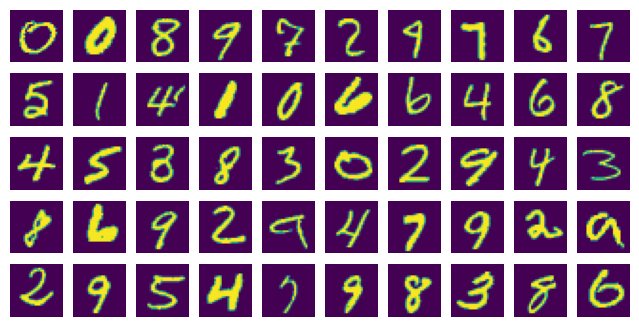

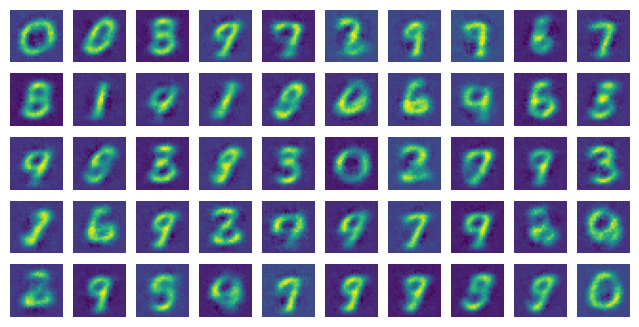

[11] loss: 0.026


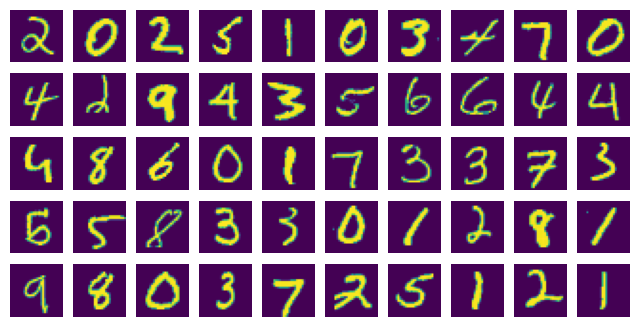

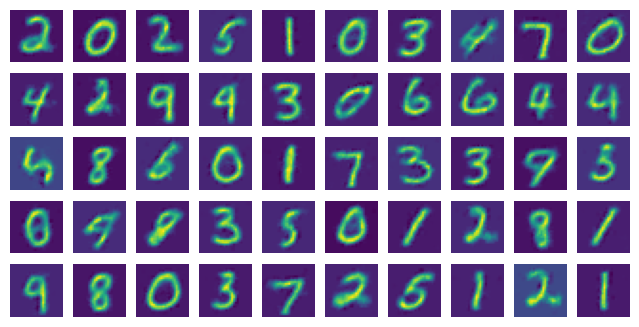

[21] loss: 0.025


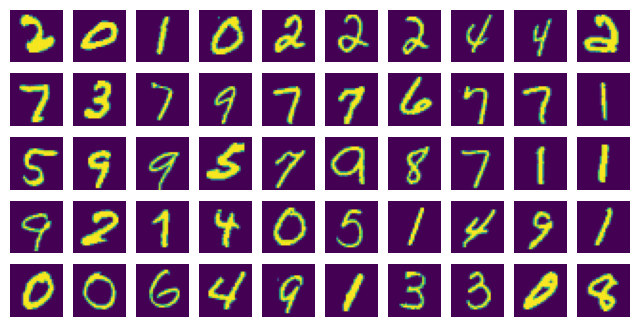

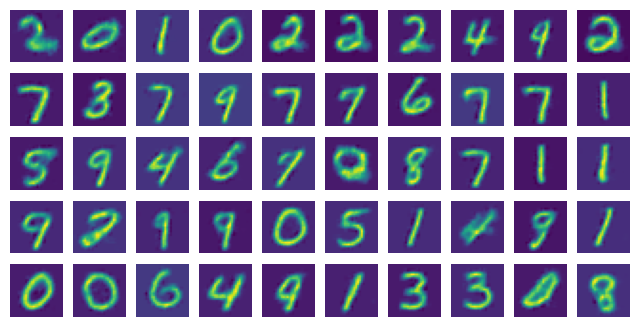

In [24]:
for epoch in range(21):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    cost = running_loss / len(trainloader)

    if epoch % 10 == 0:
        print('[%d] loss: %.3f' %(epoch + 1, cost))
        check_plot()


In [ ]:
# 장점 : 중요 특성 학습, 이미지 노이즈 제거, 데이터 복원
# 스캔 이미지 노이즈 제거, 흑백 이미지를 컬러로 복원